# Simulation of the image of a binary star with a space telescope

Let's consider an imaging system consisting of a space-based-telescope with a circular pupil and its imaging instrument being a near-infrared camera. Being space-based, the imaging system is not affected by the Earth atmosphere which results in an image quality close to the Fraunhofer diffraction equation.
For a linear imaging system ie. *Image(object1 + object2) = Image(object1) + Image(object2)*, the Point Spread Function (PSF) describes the response of a linear imaging system to a point source. In astronomy, most stars are non-resolved by single dish telescopes and can be considered as a point sources. Their observation therefore provide a direct access to the PSF of the imaging system. 

The image of binary star observed through a linear imaging system can be expressed as :
$$I_{\rm Binary}(x,y) = I_p \, psf(x-x_p,y-y_p)  + I_s \, psf(x-x_s,y-y_s)$$

where x,y are the angular coordinates expressed in arcseconds. $I_p, I_s$ are the intensities of the primary and secondary star expressed in ADU (arbitrary units) while $(x_p, y_o)$ and $(x_s, y_s)$ are the coordinates of the two stars, also expressed in arcsecond.
$psf(x,y)$ is the Point Spread Function and $I_{bin}$ is the image of the binary stars observed through the imaging system.


In the following exercise, you'll will be provided with a set of simulated observations of binary stars with different separations, contrasts and magnitudes. You will first create an analytical model of the image of the binary in the space domain (as opposed to the Fourier domain). You will then adjust the model of the binary star to the simulated observations, retrieve the binary parameters using a non-linear minimisation algorithm and assess its goodness of fit. Finally, you'll use Markov Chain Monte Carlo algorithm to probe you model parameter space and assess the confidence interval binary star parameter and their correlation.


In [1]:
from astropy.io import fits
import numpy as np
from scipy import special
from astropy.io import fits
# Set up matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
%matplotlib inline
#%matplotlib qt5

Let's first compute the PSF. For a circular pupil it is called the "Airy pattern" and is expressed as : 
$$psf(x,y)= I_{0}\, \Big(2\, \frac{J_{1}(\theta)}{\theta}\Big)^{2}$$ with $$\theta= \pi  \,\frac{D}{\lambda} \, \frac{\pi}{180\,.\,3600} r$$ and where $D$ is the diameter of the telescope, $\lambda$ is the effective wavelength of the imaging system (both expressed in meters) and $r$ is the radial distance in the focal plane (ie. on the detector) measured in arcseconds.

We compute below, the PSF of an imaging system composed of circular telescope of diameter, $D=2.40$ m,  and 
a 64 x 64 near-infrared imaging camera with a $H$ band filter of effective wavelength  $\lambda=1.65$ microns. The plate scale (or pixel scale) of the camera is  0.035 arcsecond per pixel.


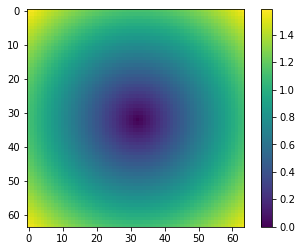

In [2]:
D_m = 2.40          # Diameter of the telescope
lbdEff_m = 1.65e-6  # Effective wavelength
pixscale = 0.035    # arcsec par pixel
Nx,Ny=64,64  # image size in pixel

x_as=pixscale*(np.arange(Nx) - Nx/2)[:,np.newaxis]
y_as=pixscale*(np.arange(Ny) - Ny/2)[np.newaxis,: ]
r_as=np.sqrt(x_as**2 + y_as**2)
plt.imshow(r_as)
plt.colorbar()

fcutD_asm1 = D_m/lbdEff_m * np.pi / (180*3600)
arg = np.pi*fcutD_asm1 *r_as
arg[arg==0]=1e-6 #protect against division by zero
psf= (2*special.jv(1, arg)/arg)**2
psf /=np.max(psf)

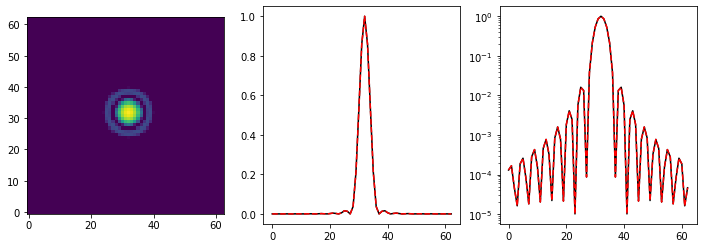

In [3]:
fig,axs = plt.subplots(1, 3, sharey=False, figsize=(12, 4))
axs[0].imshow(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2-Ny//2:Ny//2+(Ny//2-1)],norm=LogNorm(0.005, np.max(psf)), origin='lower')
axs[1].plot(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[1].plot(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red')
axs[2].semilogy(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[2].semilogy(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red',)

### Question 1.a
Write a function that computes the image of a non-resolved stars of intensity $I_0$, located at a position (dx_0,dy_0) from the center of the detector for the imaging systems of diameter D and operating a $\lambda$.

### Question 1.b
Display the image and the corresponding 1D cuts of a star with an intensity of 1500 ADU located at (0.0,0) arcseconds from the center of the detector for an imaging system with:
    1. D=2.40 m and $\lamba=1.25\,\mu$m
    2. D=3.60 m and $\lamba=1.25\,\mu$m
    3. D=3.60 m and $\lamba=2.2\,\mu$m

### Question 1.c
Explain what you are observing.

### Question 1.d
From now on, you will consider a telescope of diameter 3.60 meter observing at $\lamba=1.65\,\mu$m.

Display the image of a star with an intensity of 1500 ADU located at (0.35,-0.7) arcseconds from the center of the detector.

In [4]:
def computeImageSingleStar(I0, dx0_as,dy0_as, D=3.60, lam=2.20e-6):
    D_m = D       # Diameter of the telescope
    lbdEff_m = lam  # Effective wavelength
    pixscale = 0.035    # arcsec par pixel
    Nx,Ny=64,64  # image size in pixel
    
    x_as=pixscale*(np.arange(Nx) - Nx/2)[:,np.newaxis]
    y_as=pixscale*(np.arange(Ny) - Ny/2)[np.newaxis,: ]
    r_as=np.sqrt((x_as-dx0_as)**2 + (y_as- dy0_as)**2)
    #plt.imshow(r_as)
    #plt.colorbar()
    
    fcutD_asm1 = D_m/lbdEff_m * np.pi / (180*3600)
    reso = 1/fcutD_asm1
    #print('The angular resolution is ', reso)
    arg = np.pi*fcutD_asm1 *r_as
    arg[arg==0]=1e-6 #protect against division by zero
    psf= I0*(2*special.jv(1, arg)/arg)**2
    return psf

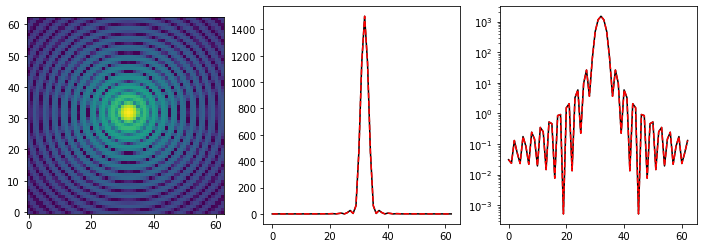

In [5]:
psf=computeImageSingleStar(I0 = 1500, D=2.40, lam=1.25e-6, dx0_as=0., dy0_as=0.)
fig,axs = plt.subplots(1, 3, sharey=False, figsize=(12, 4))
axs[0].imshow(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2-Ny//2:Ny//2+(Ny//2-1)],norm=LogNorm(0.005, np.max(psf)), origin='lower')
axs[1].plot(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[1].plot(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red')
axs[2].semilogy(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[2].semilogy(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red',)

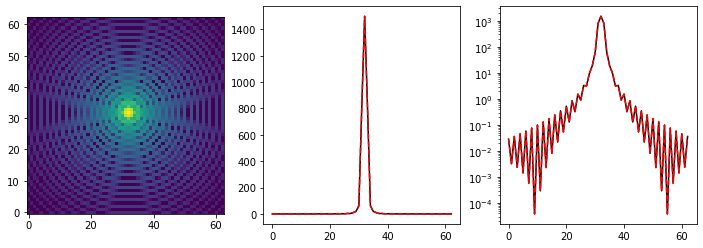

In [6]:
psf=computeImageSingleStar(I0 = 1500, D=3.60, lam=1.25e-6, dx0_as=0., dy0_as=0.)
fig,axs = plt.subplots(1, 3, sharey=False, figsize=(12, 4))
axs[0].imshow(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2-Ny//2:Ny//2+(Ny//2-1)],norm=LogNorm(0.005, np.max(psf)), origin='lower')
axs[1].plot(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[1].plot(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red')
axs[2].semilogy(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[2].semilogy(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red',)

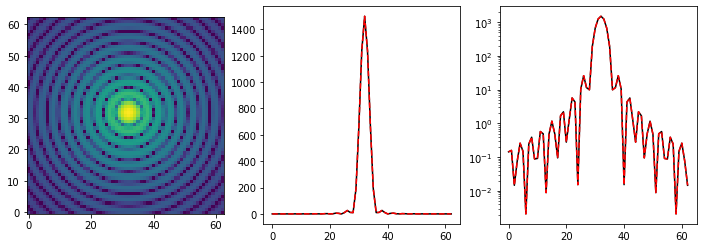

In [7]:
psf=computeImageSingleStar(I0 = 1500, D=3.60, lam=2.2e-6, dx0_as=0., dy0_as=0.)
fig,axs = plt.subplots(1, 3, sharey=False, figsize=(12, 4))
axs[0].imshow(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2-Ny//2:Ny//2+(Ny//2-1)],norm=LogNorm(0.005, np.max(psf)), origin='lower')
axs[1].plot(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[1].plot(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red')
axs[2].semilogy(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
axs[2].semilogy(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red',)

### Question 2.a
Write a function that computes the image of a binary star composed of two non-resolved stars using the imaging devices described previously.
The primary star has an intensity $I_0$ and is located close to the center of the detector $(dx_0,dy_0)$ while the secondary star has an intensity $I_1$ and is located at  $(dx_1,dy_1)$.



In [8]:
def computeImageBinaryStar(params):
    I0,dx0_as,dy0_as,I1,dx1_as,dy1_as=params
    s1 = computeImageSingleStar(I0, dx0_as, dy0_as)
    s2 = computeImageSingleStar(I1, dx1_as, dy1_as)
    s3 = s1 + s2
    return s3

### Question 2.b
Display the image of a binary star with :
    -(I0,dx_0,dy_0)==(1500,0.05,-0.2) and (I1,dx_1,dy_1)==(1000,0.45,+0.25).
    -(I0,dx_0,dy_0)==(1500,0.05,-0.2) and (I1,dx_1,dy_1)==(100,-0.25,+0.2).

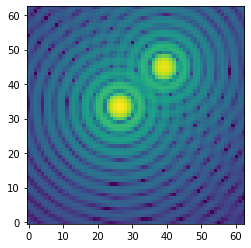

In [9]:
params = [1500, 0.05, -0.2, 1000, 0.45, 0.25]
psf=computeImageBinaryStar(params)
fig,axs = plt.subplots(1, 1, figsize=(12, 4))
axs.imshow(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2-Ny//2:Ny//2+(Ny//2-1)],norm=LogNorm(0.005, np.max(psf)), origin='lower')
#axs[1].plot(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
#axs[1].plot(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red')
#axs[2].semilogy(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
#axs[2].semilogy(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red',)

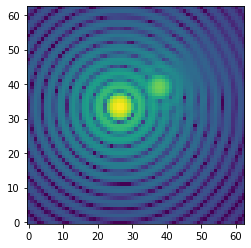

In [10]:
params = [1500, 0.05, -0.2, 100, 0.25, 0.2]
psf=computeImageBinaryStar(params)
fig,axs = plt.subplots(1, 1, figsize=(12, 4))
axs.imshow(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2-Ny//2:Ny//2+(Ny//2-1)],norm=LogNorm(0.005, np.max(psf)), origin='lower')
#axs[1].plot(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
#axs[1].plot(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red')
#axs[2].semilogy(psf[Nx//2-Nx//2:Nx//2+(Nx//2-1),Ny//2],color='k')
#axs[2].semilogy(psf[Nx//2,Ny//2-Ny//2:Ny//2+(Ny//2-1)],'--',color='red',)

### Question 2.c
A set of simulated binary star images can be downloaded from the Moodle platform. They correspond to stars of different constrast and signal to noise observations. 

### Question 2.d
Load the images.   What information can you extract from the fitsheaders ?

### Question 2.e
Could you provide an estimate of the noise standard deviation in the image? 


In [11]:
#Enter the path where you've store your images
import os
pathData=os.getcwd()#'/Users/Damien/Projects/masterClass/ImageFormationAndBinaries-20201201/'
#Open psf
imageBinary = fits.getdata(pathData+'/LowContrastBinaryShortSeparation_CubeOfImages.fits')
hdul = fits.open(pathData+'/LowContrastBinaryShortSeparation_CubeOfImages.fits')
h1 = hdul[0].header
h1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   64                                                  
NAXIS2  =                   64                                                  
NAXIS3  =                 1200                                                  
HIERARCH Julian Date = 2457733.4585                                             
LAMBDA  =             1.65E-06                                                  
PIXSCALE=                0.035                                                  
MODEL   = '15000,0.05,-0.2,7000,0.45,+0.25'                                     
RON     =                  5.0                                                  

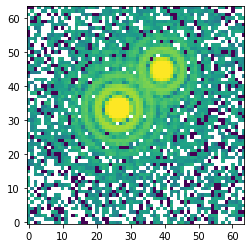

In [12]:
plt.imshow(imageBinary[np.random.randint(1,1199)], norm=LogNorm(0.005, np.max(psf)), origin='lower')

### Question 3 - Model fitting - Chi2 minimization
In order to estimate the parameters of the binary star model, you'll need to write a function that computes the chi2. 

In [13]:
def residuals(params, ImObs):
    model1 = computeImageBinaryStar(params)
    resi = ImObs - model1
    return resi

def computeChi2(params, sigma2, ImObs):
    resid = residuals(params, ImObs)
    chi = resid**2/sigma2
    chi2 = np.sum(chi)
    return chi2

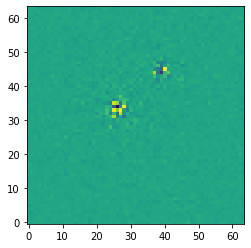

Value of reduced Chi2  5.100037187849371
Std of residulas  11.282471755656099


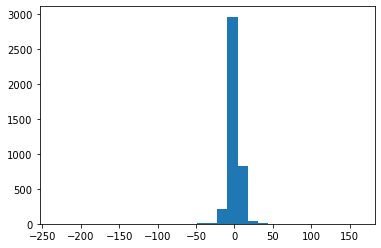

In [14]:
initial = np.array([15000,0.05,-0.2,7000,0.45,+0.25])
sigma2=25
obs = imageBinary[0,:,:]
f1 = residuals(initial, obs)
chi2r = computeChi2(initial, sigma2, obs)/(Nx*Ny-6)
plt.imshow(f1, origin='lower')
plt.show()
plt.hist(f1.flatten(), bins=30)
print('Value of reduced Chi2 ', chi2r)
print('Std of residulas ', np.std(f1.flatten()))

### Question 3.a


You are expected to use here the minimize function of the scipy package.
Perform the fit with :
     -the first slice of the image cube and a sigma2=25
     -the first slice of the image cube and a sigma2=3800



Compute the $\chi^2$ and the reduced $\chi^2$. 

What is the value of the expected $\chi^2$ for this model? 

Did the fit converge? 

What are the differences between the two fit? Which one the two solution is the correct one? Explain

    Perform the fit with :
        -the mean image (average over the first dimension) with sigma2=25
        -the mean image(average over the first dimension)  a sigma2=3800

    Did the fit converge?
    What are the differences between the two fit? Which one the two solution is the correct one? Explain


    Perform the fit with :
        -the mean image(average over the first dimension)  a sigma2=3800/sqrt(Nimages).  Comment.




In [15]:
from scipy.optimize import minimize

soln = minimize(computeChi2, initial,
                args=(sigma2,imageBinary[0,:,:]), 
                method='BFGS', options={'gtol':1e-6, 'disp':True})

#The  chi2 derived from the minimization is stored in soln.fun 
#The estimated values for the model parameters are stored in soln.x
print(soln)



         Current function value: 20160.557158
         Iterations: 18
         Function evaluations: 1354
         Gradient evaluations: 167
      fun: 20160.55715770997
 hess_inv: array([[ 1.39430056e-02,  1.17387996e-07,  5.73623280e-09,
         1.21608096e-02, -3.13549117e-07,  4.89550190e-07],
       [ 1.17387995e-07,  4.14598627e-11,  2.25022610e-13,
         1.02903039e-07, -6.83460686e-12,  1.12368900e-11],
       [ 5.73623282e-09,  2.25033249e-13,  3.88898053e-11,
         4.27633204e-09, -9.78151966e-13,  7.15324222e-14],
       [ 1.21608096e-02,  1.02903039e-07,  4.27633201e-09,
         1.06282610e-02, -2.74176032e-07,  4.29311417e-07],
       [-3.13549117e-07, -6.83461118e-12, -9.78155382e-13,
        -2.74176032e-07,  1.98262009e-10, -2.56594673e-11],
       [ 4.89550191e-07,  1.12368855e-11,  7.15404932e-14,
         4.29311417e-07, -2.56594719e-11,  2.28458819e-10]])
      jac: array([-1.46484375e-03,  5.75683594e+00,  2.06787109e-01,  2.68554688e-03,
       -3.36328125

In [16]:
I0e1,dx0e1_as,dy0e1_as,I1e1,dx1e1_as,dy1e1_as = soln.x
print("Minimum Chi2 estimates:")
print('chi2=%6.2f '%(soln.fun))
print('Ip = %12.2f'%(I0e1))
print('xp = %12.3f'%(dx0e1_as))
print('yp = %12.3f'%(dy0e1_as))
print('Is = %12.2f'%(I1e1))
print('xs = %12.3f'%(dx1e1_as))
print('ys = %12.3f'%(dy1e1_as))

Minimum Chi2 estimates:
chi2=20160.56 
Ip =     15017.72
xp =        0.050
yp =       -0.200
Is =      6971.73
xs =        0.450
ys =        0.250


## With sigma2=11**2

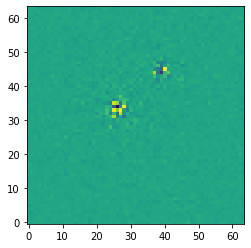

Value of reduced Chi2  0.03355287623585112
Std of residulas  11.282471755656099
         Current function value: 132.635244
         Iterations: 34
         Function evaluations: 1203
         Gradient evaluations: 149
      fun: 132.6352444788044
 hess_inv: array([[ 3.34494738e-01, -8.64785342e-06,  7.45545864e-06,
         1.46781894e-01,  9.84880912e-06, -6.71394986e-05],
       [-8.64785342e-06,  7.52566767e-09, -1.41679000e-09,
        -3.91016823e-06, -1.87109930e-09,  1.28310752e-08],
       [ 7.45545864e-06, -1.41679001e-09,  7.13062976e-09,
         3.43053198e-06,  1.63539433e-09, -1.11724191e-08],
       [ 1.46781894e-01, -3.91016823e-06,  3.43053198e-06,
         6.52163351e-02,  4.48203389e-06, -3.06812775e-05],
       [ 9.84880912e-06, -1.87109930e-09,  1.63539434e-09,
         4.48203389e-06,  2.92620584e-08, -1.46703084e-08],
       [-6.71394986e-05,  1.28310752e-08, -1.11724191e-08,
        -3.06812775e-05, -1.46703084e-08,  1.27806440e-07]])
      jac: array([ 5.72204

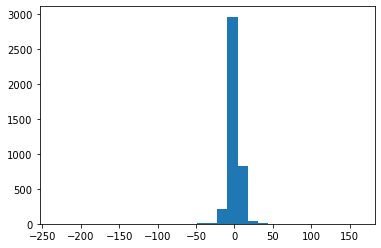

In [17]:
initial = np.array([15000,0.05,-0.2,7000,0.45,+0.25])
sigma2=3800
obs = imageBinary[0,:,:]
f1 = residuals(initial, obs)
chi2r = computeChi2(initial, sigma2, obs)/(Nx*Ny-6)
plt.imshow(f1, origin='lower')
plt.show()
plt.hist(f1.flatten(), bins=30)
print('Value of reduced Chi2 ', chi2r)
print('Std of residulas ', np.std(f1.flatten()))

from scipy.optimize import minimize

soln = minimize(computeChi2, initial,
                args=(sigma2,imageBinary[0,:,:]), 
                method='BFGS', options={'gtol':1e-6, 'disp':True})

#The  chi2 derived from the minimization is stored in soln.fun 
#The estimated values for the model parameters are stored in soln.x
print(soln)

In [18]:
I0e1,dx0e1_as,dy0e1_as,I1e1,dx1e1_as,dy1e1_as = soln.x
print("Minimum Chi2 estimates:")
print('chi2=%6.2f '%(soln.fun))
print('Ip = %12.2f'%(I0e1))
print('xp = %12.3f'%(dx0e1_as))
print('yp = %12.3f'%(dy0e1_as))
print('Is = %12.2f'%(I1e1))
print('xs = %12.3f'%(dx1e1_as))
print('ys = %12.3f'%(dy1e1_as))

Minimum Chi2 estimates:
chi2=132.64 
Ip =     15017.72
xp =        0.050
yp =       -0.200
Is =      6971.73
xs =        0.450
ys =        0.250


## Noise distribution

$$\sigma^2(i,j) = \sigma_{\rm det}^2 \delta_{i,j} + K_{i,j}$$

### Question 4 - Model fitting - Use of a MCMC package
In order to perform the mcmc, you need to install the following packages.

> pip install emcee

> pip install corner

The documentation of emcee is available at : https://emcee.readthedocs.io/en/stable/tutorials/line/


You have seen in the previous classes that minimizing the chi2 is equivalent to maximizing the likelihood function when the variance of the noise is known.
From  Question 3, you should have concluded that you were not able to correctly estimate the noise in the image.


Here you will write alikelihood function where the standard deviation of the noise (assuming a gaussian white noise) is also adjusted.

In [19]:
def computeFlatImResiduals(params, flatImageBinaryObs):
    ImBinaryModel = computeImageBinaryStar(params)
    flatResiduals = flatImageBinaryObs - ImBinaryModel.flatten()
    return flatResiduals 
    
def computeChi2FlatIm(params, sigma2, flatImObs):
    res = computeFlatImResiduals(params, flatImObs)
    #hipothesis to speed up computation
    #same noise everywhere on the detector
    chi2 = np.sum(res**2/sigma2)
    return chi2

In [20]:
def logLikelihood(theta, imageBinaryObsFlat):
    sigJit=theta[0]
    params=theta[1:]
    sigma2 = sigJit**2
    yy = computeChi2FlatIm(params, sigJit**2, imageBinaryObsFlat)
    lnLikelihood = - 0.5*yy - 0.5*Nx*Ny*np.log(sigma2)
    return lnLikelihood

The emcee algorithm runs several "walkers" in parallel. Each walker is composed of the vectors of parameter to be adjusted. We are adjusting here 7 parameters (1 noise parameter + 6 model parameter) and we choose to use 32 walkers. If your computer is to slow, you can try to reduce the number of walker to 16.


In [21]:
import emcee
nwalkers,ndim = 32,7

Each walker should be initialized with a different starting value. We choose to randomly draw the initial conditions according to a normal distribution as shown below. The mean and stdev of the parameters are provided in order to gain time.

In [22]:
thetaInitAvg=np.array([5,15000,0.05,-0.2,7000,0.45,+0.25])
thetaTruth  =np.array([5,15000,0.05,-0.2,7000,0.45,+0.25])


thetaInitStd=np.array([5,6,pixscale/50,pixscale/50,4,pixscale/50,pixscale/50])

#Initialize the walkers
posInit = thetaInitAvg[np.newaxis,:] + thetaInitStd[np.newaxis,:] * np.random.randn(nwalkers,ndim)

Run the MCMC on the first slice of the image

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                logLikelihood, 
                                args=(imageBinary[0,:,:].flatten(),))

sampler.run_mcmc(posInit, 1000, progress=True)

100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


State([[ 1.10865481e+01  1.50173416e+04  4.99281744e-02 -1.99929467e-01
   6.97925235e+03  4.50036478e-01  2.50299606e-01]
 [ 1.10891985e+01  1.50206497e+04  4.99140922e-02 -1.99969636e-01
   6.97414188e+03  4.49936172e-01  2.50310430e-01]
 [ 1.10492644e+01  1.50209617e+04  4.99367085e-02 -1.99951017e-01
   6.97466732e+03  4.49947594e-01  2.50308155e-01]
 [ 1.12046192e+01  1.50174699e+04  4.99282074e-02 -1.99951968e-01
   6.97174997e+03  4.50021743e-01  2.50337264e-01]
 [-1.10372944e+01  1.50081073e+04  4.99199114e-02 -1.99941179e-01
   6.99588472e+03  4.50004831e-01  2.50284452e-01]
 [ 1.12284575e+01  1.50119510e+04  4.99172412e-02 -1.99977075e-01
   6.97383829e+03  4.49951713e-01  2.50276627e-01]
 [ 1.13300896e+01  1.50181590e+04  4.99267610e-02 -1.99946707e-01
   6.97211804e+03  4.49996670e-01  2.50398855e-01]
 [-1.12950266e+01  1.50171050e+04  4.99220465e-02 -1.99964341e-01
   6.99476187e+03  4.50112261e-01  2.50240008e-01]
 [ 1.12240657e+01  1.50143381e+04  4.99499989e-02 -1.99953

Display the mcmc chains/walkers of the different parameters that you have adjusted

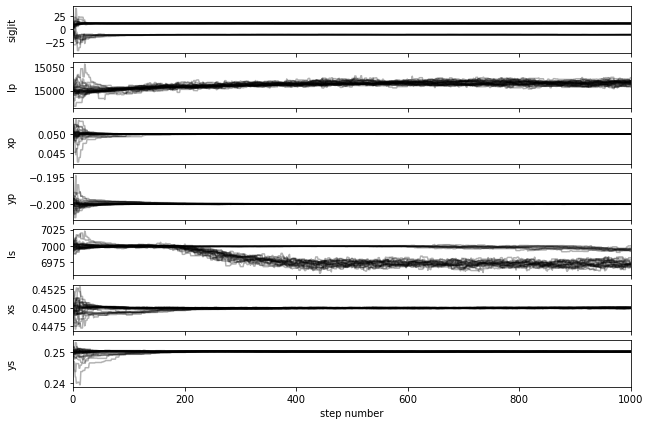

In [25]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['sigJit',"Ip", "xp", "yp",'Is','xs','ys']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");



What do you notice? 

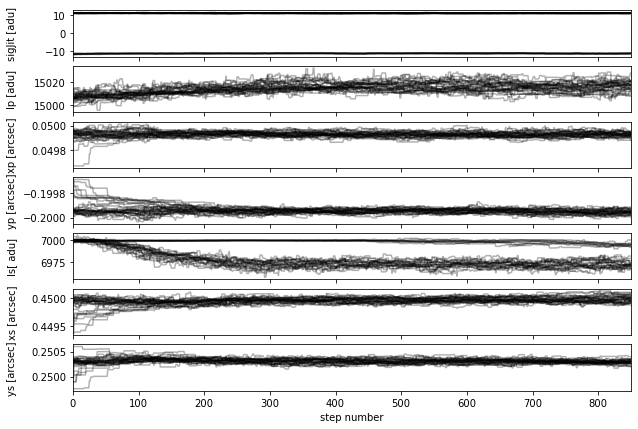

In [28]:
discard = 150
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['sigJit [adu]',"Ip [adu]", "xp [arcsec]", "yp [arcsec]",'Is[ adu]','xs [arcsec]','ys [arcsec]']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[discard:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-discard)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


Compute the mean, the median and the standard deviation of each parameter and list their values.
How does it compare to the chi2 minimisation results?


In [30]:
flat_samples = sampler.get_chain(discard=150, thin=1, flat=True)
#compute the mean, median and std of the flat_samples

In [31]:
#sigjit, I0e1,dx0e1_as,dy0e1_as,I1e1,dx1e1_as,dy1e1_as
#len(flat_samples[:,0])

sigjit = flat_samples[:,0]
I0e1 = flat_samples[:,1]
dx0e1_as = flat_samples[:,2]
dy0e1_as = flat_samples[:,3]

I1e1 = flat_samples[:,4]
dx1e1_as = flat_samples[:,5]
dy1e1_as = flat_samples[:,6]

print('Sigma jitter- Mean: ' + str(np.mean(sigjit)) + '\t Std: ' + str(np.std(sigjit)))
print('I0- Mean: ' + str(np.mean(I0e1)) + '\t Std: ' + str(np.std(I0e1)))
print('Dx0- Mean: ' + str(np.mean(dx0e1_as)) + '\t Std: ' + str(np.std(dx0e1_as)))
print('Dy0- Mean: ' + str(np.mean(dy0e1_as)) + '\t Std: ' + str(np.std(dy0e1_as)))
print('       ')
print('I1- Mean: ' + str(np.mean(I1e1)) + '\t Std: ' + str(np.std(I1e1)))
print('Dx1- Mean: ' + str(np.mean(dx1e1_as)) + '\t Std: ' + str(np.std(dx1e1_as)))
print('Dy1- Mean: ' + str(np.mean(dy1e1_as)) + '\t Std: ' + str(np.std(dy1e1_as)))

Sigma jitter- Mean: 4.163347595103762	 Std: 10.326398713965888
I0- Mean: 15014.634727720691	 Std: 4.563652691585366
Dx0- Mean: 0.04992767377229607	 Std: 2.3619197731000852e-05
Dy0- Mean: -0.19994108700500782	 Std: 3.1061494130940205e-05
       
I1- Mean: 6983.5443207622	 Std: 12.408588911579304
Dx1- Mean: 0.44995778696399685	 Std: 6.49819426109883e-05
Dy1- Mean: 0.25030938812821407	 Std: 5.5426604440094446e-05


Correlations between the different parameters are directly accessible (and easily computed) from the MCMC posterior distributions. 
Compte the variances and covariances of the model parameters using the mcmc posterior distributions (fla_samples)

The correlation can easily be visualized using the corner package. Does the visualisation corroborates the results you obtained above?

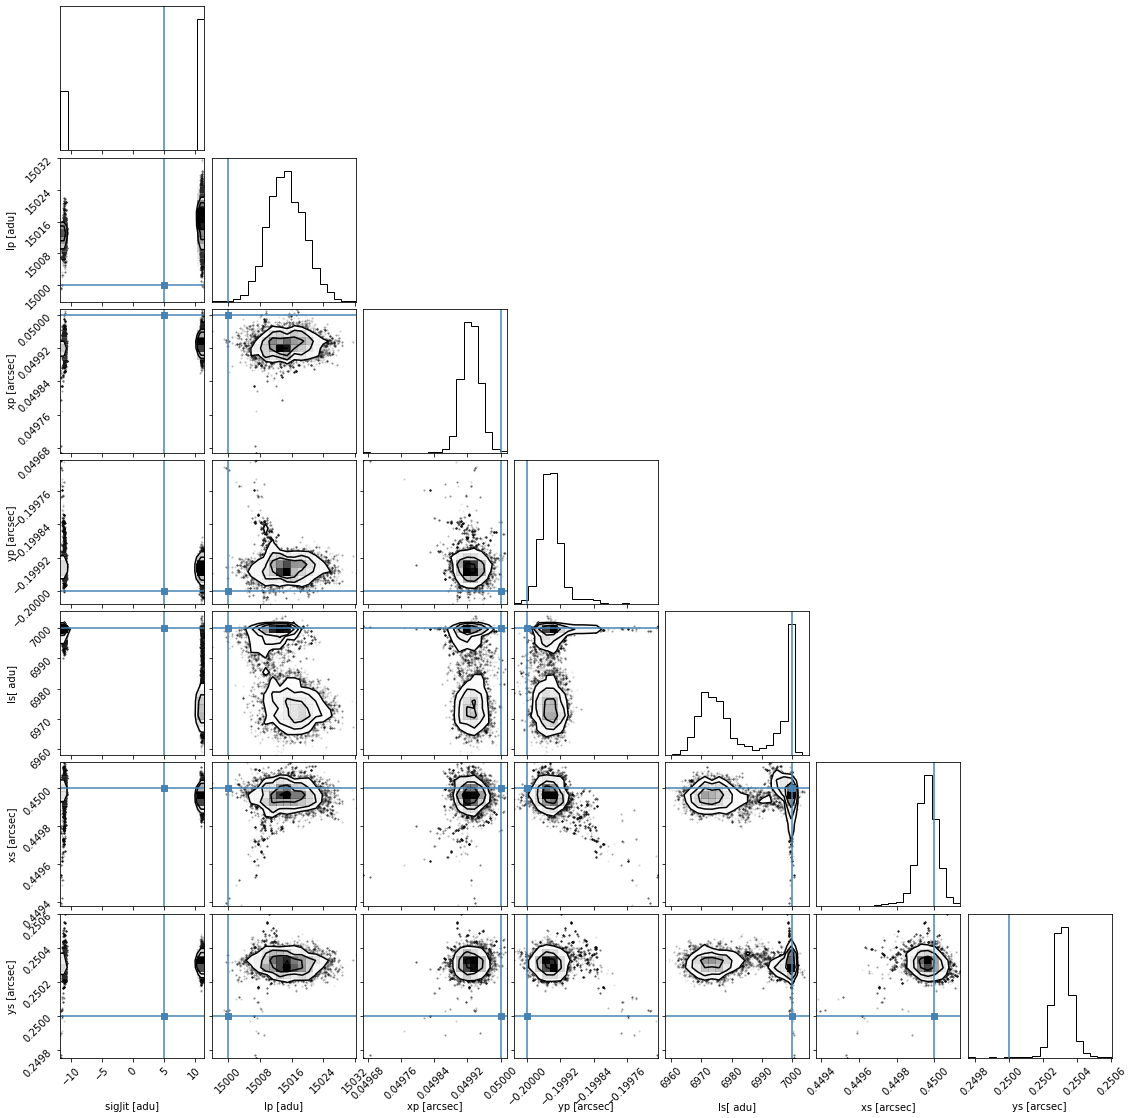

In [32]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=thetaTruth
);
